In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef)
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [2]:
scaler = MinMaxScaler()


def load_dataset(data_path, n_features, seed):
    """
    HAR local -> filtra 3 clases (1=WALKING, 4=SITTING, 6=LAYING),
    StandardScaler -> PCA (fit en train) -> MinMaxScaler a [-1,1] sobre los scores de PCA.
    Devuelve: X_train_final, y_train, X_test_final, y_test, explained_variance
    """
    data_path = Path(data_path)

    # --- nombres únicos de features ---
    raw_feats = pd.read_csv(
        data_path / "features.txt", sep=r"\s+", header=None, names=["idx", "feature"]
    )["feature"].tolist()

    def make_unique(names):
        seen, out = {}, []
        for n in names:
            k = seen.get(n, 0)
            out.append(n if k == 0 else f"{n}_{k}")
            seen[n] = k + 1
        return out

    features = make_unique(raw_feats)

    # --- cargar train/test ---
    X_train = pd.read_csv(data_path / "train" / "X_train.txt",
                          sep=r"\s+", header=None, names=features)
    y_train = pd.read_csv(data_path / "train" / "y_train.txt",
                          sep=r"\s+", header=None, names=["activity"])

    X_test  = pd.read_csv(data_path / "test" / "X_test.txt",
                          sep=r"\s+", header=None, names=features)
    y_test  = pd.read_csv(data_path / "test" / "y_test.txt",
                          sep=r"\s+", header=None, names=["activity"])

    # --- filtrar 3 clases ---
    keep = [1, 4, 6]  # 1=WALKING, 4=SITTING, 6=LAYING
    mtr = y_train["activity"].isin(keep)
    mte = y_test["activity"].isin(keep)
    X_train, y_train = X_train[mtr], y_train[mtr].reset_index(drop=True)
    X_test,  y_test  = X_test[mte],  y_test[mte].reset_index(drop=True)

    # re-etiquetar a 0,1,2
    mapping = {cls: i for i, cls in enumerate(keep)}
    y_train = y_train["activity"].map(mapping).values
    y_test  = y_test["activity"].map(mapping).values

    # --- 1) StandardScaler antes del PCA ---
    std_scaler = StandardScaler()
    X_train_std = std_scaler.fit_transform(X_train)
    X_test_std  = std_scaler.transform(X_test)

    # --- 2) PCA (fit en train) ---
    pca = PCA(n_components=n_features)
    Z_train = pca.fit_transform(X_train_std)
    Z_test  = pca.transform(X_test_std)
    explained_var = pca.explained_variance_ratio_.sum()

    # --- 3) MinMaxScaler a [-1,1] sobre los scores de PCA ---
    mm_scaler = MinMaxScaler(feature_range=(-1, 1))
    X_train_final = mm_scaler.fit_transform(Z_train)
    X_test_final  = mm_scaler.transform(Z_test)

    
    # --- 4) Shuffle con semilla reproducible ---
    X_train_final, y_train = shuffle(X_train_final, y_train, random_state=seed)
    X_test_final,  y_test  = shuffle(X_test_final,  y_test,  random_state=seed)


    return X_train_final, y_train, X_test_final, y_test, explained_var


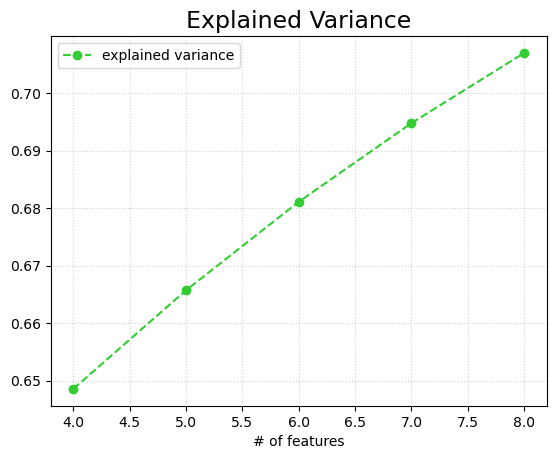

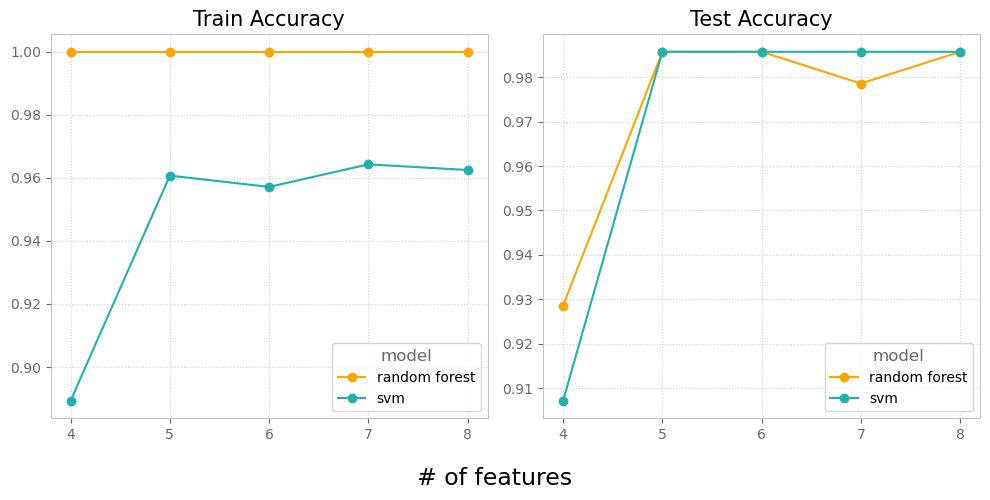

In [9]:
n = np.arange(4, 9, 1)

explained_variance    = []

# Métricas Random Forest
train_accuracy_rf, test_accuracy_rf = [], []
test_precision_rf, test_recall_rf = [], []
test_f1_rf, test_kappa_rf, test_mcc_rf = [], [], []

# Métricas SVM
train_accuracy_svm, test_accuracy_svm = [], []
test_precision_svm, test_recall_svm = [], []
test_f1_svm, test_kappa_svm, test_mcc_svm = [], [], []

for NUM_FEATURES in n:
    data_path = "/Users/ccristiano/Documents/Codigos/QML/HAR/UCI HAR Dataset"

    X_train_0, y_train_0, X_test_0, y_test_0, exp_var = load_dataset(data_path, NUM_FEATURES, 42)

    X_train = X_train_0[:560]
    y_train = y_train_0[:560]
    X_test = X_test_0[:140]
    y_test = y_test_0[:140]

    explained_variance.append(exp_var)

    # === Random Forest ===
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    y_train_pred_rf = rf_model.predict(X_train)
    y_test_pred_rf = rf_model.predict(X_test)

    train_accuracy_rf.append(accuracy_score(y_train, y_train_pred_rf))
    test_accuracy_rf.append(accuracy_score(y_test, y_test_pred_rf))
    test_precision_rf.append(precision_score(y_test, y_test_pred_rf, average='weighted', zero_division=0))
    test_recall_rf.append(recall_score(y_test, y_test_pred_rf, average='weighted', zero_division=0))
    test_f1_rf.append(f1_score(y_test, y_test_pred_rf, average='weighted', zero_division=0))
    test_kappa_rf.append(cohen_kappa_score(y_test, y_test_pred_rf))
    test_mcc_rf.append(matthews_corrcoef(y_test, y_test_pred_rf))

    # === SVM ===
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train, y_train)

    y_train_pred_svm = svm_model.predict(X_train)
    y_test_pred_svm = svm_model.predict(X_test)

    train_accuracy_svm.append(accuracy_score(y_train, y_train_pred_svm))
    test_accuracy_svm.append(accuracy_score(y_test, y_test_pred_svm))
    test_precision_svm.append(precision_score(y_test, y_test_pred_svm, average='weighted', zero_division=0))
    test_recall_svm.append(recall_score(y_test, y_test_pred_svm, average='weighted', zero_division=0))
    test_f1_svm.append(f1_score(y_test, y_test_pred_svm, average='weighted', zero_division=0))
    test_kappa_svm.append(cohen_kappa_score(y_test, y_test_pred_svm))
    test_mcc_svm.append(matthews_corrcoef(y_test, y_test_pred_svm))

# Plot explained variance
plt.figure()
plt.plot(n, np.array(explained_variance), color='limegreen', marker='o', ls='--', label='explained variance')
plt.grid(ls='dotted', color='lightgray')
plt.xlabel("# of features")
plt.title("Explained Variance", fontsize=17)
plt.legend()


# Plot metrics
metrics_rf  = [train_accuracy_rf, test_accuracy_rf]
metrics_svm = [train_accuracy_svm, test_accuracy_svm]
palette = sns.color_palette('hls', 4)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
custom_labels = [f"{ni}" for ni in n]
subplot_titles = ["Train Accuracy", "Test Accuracy"]
axes[0].plot(n, np.array(metrics_rf[0]), color='orange', linestyle="-", marker="o", markersize=6, label="random forest")
axes[0].plot(n, np.array(metrics_svm[0]), color='lightseagreen', linestyle="-", marker="o", markersize=6, label="svm")
axes[1].plot(n, np.array(metrics_rf[1]), color='orange', linestyle="-", marker="o", markersize=6, label="random forest")
axes[1].plot(n, np.array(metrics_svm[1]), color='lightseagreen', linestyle="-", marker="o", markersize=6, label="svm")
for i, ax in enumerate(axes.flat):
    for spine in ax.spines.values():
        spine.set_edgecolor("silver")
        spine.set_linewidth(0.7) 
    ax.set_xticks(range(4,9))
    ax.set_xticklabels(custom_labels, fontsize=10)
    ax.set_title(subplot_titles[i], fontsize=15)
    ax.grid(True, color='lightgrey', ls='dotted')
    ax.legend(title="model", title_fontsize=12) 
    ax.tick_params(axis='both', colors='dimgrey')
    ax.get_legend().get_title().set_color("dimgrey")
fig.supxlabel("# of features", fontsize=17)
plt.tight_layout()
plt.show()
